In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import MNISTtools

In [17]:
x_train, y_train = MNISTtools.load(dataset='training')
x_test, y_test = MNISTtools.load(dataset='testing')
print("x_train.shape=",x_train.shape)
print("y_train.shape=",y_train.shape)
print("x_test.shape=",x_test.shape)

x_train.shape= (784, 60000)
y_train.shape= (60000,)
x_test.shape= (784, 10000)


To reduce the computation cost, we only select a small part of $n$ images for further analysis. _You might modify this value later to visualise its influence on the results._


In [18]:
n = 7000
x_train = x_train[:,1:n+1]
y_train = y_train[1:n+1]

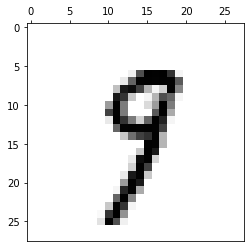

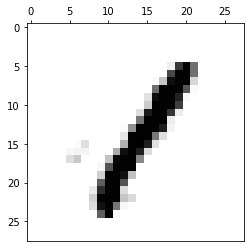

In [19]:
x_test_im = x_test.reshape((28, 28, 1, -1))
x_train_im = x_train.reshape((28, 28, 1, -1))
MNISTtools.show(x_train_im[:, :, 0, 42])
plt.show()
MNISTtools.show(x_train_im[:, :, 0, 200])
plt.show()

In [20]:
x_train_im=x_train.T.reshape((-1,1,28, 28))
x_test_im=x_test.T.reshape((-1,1,28,28))
print("x_test_im.shape=",x_test_im.shape)

x_test_im.shape= (10000, 1, 28, 28)


In [21]:
def normalize_MNIST_images(x):
    return 2 * x.astype(np.float32) / 255. - 1
x_train_im = normalize_MNIST_images(x_train_im)
x_test_im = normalize_MNIST_images(x_test_im)


In [22]:
print(x_train_im.shape)
x_train_torch = torch.from_numpy(x_train_im)
print(x_train_torch.shape)
y_train_torch = torch.from_numpy(y_train)
x_test_torch = torch.from_numpy(x_test_im)
print(x_test_torch.shape)
y_test_torch = torch.from_numpy(y_test)

(7000, 1, 28, 28)
torch.Size([7000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


In [23]:
'''#define the same network as in the next notebook but with a different'''
'''#  architecture so that the last layer before the final linear linear is of size 128
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3, 1)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.dropout1 = nn.Dropout2d(0.25)
#         self.dropout2 = nn.Dropout2d(0.5)
#         self.fc1 = nn.Linear(9216, 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)




# net = Net()
# print(net)    '''


'#  architecture so that the last layer before the final linear linear is of size 128\n# class Net(nn.Module):\n#     def __init__(self):\n#         super(Net, self).__init__()\n#         self.conv1 = nn.Conv2d(1, 32, 3, 1)\n#         self.conv2 = nn.Conv2d(32, 64, 3, 1)\n#         self.dropout1 = nn.Dropout2d(0.25)\n#         self.dropout2 = nn.Dropout2d(0.5)\n#         self.fc1 = nn.Linear(9216, 128)\n#         self.fc2 = nn.Linear(128, 10)\n\n#     def forward(self, x):\n#         x = self.conv1(x)\n#         x = F.relu(x)\n#         x = self.conv2(x)\n#         x = F.relu(x)\n#         x = F.max_pool2d(x, 2)\n#         x = self.dropout1(x)\n#         x = torch.flatten(x, 1)\n#         x = self.fc1(x)\n#         x = F.relu(x)\n#         x = self.dropout2(x)\n#         x = self.fc2(x)\n#         return F.log_softmax(x, dim=1)\n\n\n\n\n# net = Net()\n# print(net)    '

In [24]:
# The neural networks class
class LeNet(nn.Module):
#16*16=
    # define our network structure
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6 , 5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*4*4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    # define one forward pass through the network
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))# COMPLETE
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = self.fc4(x)
        return x
    
    # helper function to understand the dimensions
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        return np.prod(size)

net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [25]:
with torch.no_grad():
    pred = net(x_test_torch)

In [26]:
# T: number of epochs
# B: minibatch size, 
# gamma: step size,
# rho: momentum.
from math import ceil
def backprop_deep(x_train, y_train, net, T, B=100, gamma=.001, rho=.9):
    N = x_train.size()[0]        # Training set size
    NB = N//B   # Number of minibatches
    print(NB)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=rho) 
    
    loss_values = []
    for epoch in range(T):
        running_loss = 0.0
        shuffled_indices = np.random.permutation(range(N))
        for k in range(NB):
            # Extract k-th minibatch from xtrain and ltrain
            minibatch_indices = shuffled_indices[B*k:min(B*(k+1), N)]
            inputs = x_train[minibatch_indices]
            labels = y_train[minibatch_indices]

            # Initialize the gradients to zero
            optimizer.zero_grad()

            # Forward propogation
            outputs = net(inputs) 

            # Error evaluation
            loss = criterion(outputs, labels)

            # Back propogation
            loss.backward()
             

            # Optimize step
            optimizer.step()

            # Compute and print statistics
            with torch.no_grad():
                running_loss += loss.item()*inputs.size(0)
  
            
        loss_values.append(running_loss/NB)
  
    plt.plot(loss_values)
    return net

70


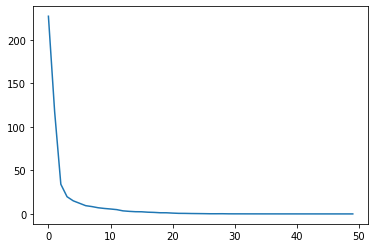

In [27]:
y_train_torch = y_train_torch.long()
net = backprop_deep(x_train_torch, y_train_torch, net, T=50)

In [28]:
with torch.no_grad():
    y=net(x_train_torch)
#     print(y)
_, pred_labels_sgd = y.max(1)
print("précision pour les données d'entraînement=",100 * (y_train_torch == pred_labels_sgd).float().mean())




with torch.no_grad():
    y=net(x_test_torch)
_, pred_labels_sgd = y.max(1)
print("précision pour les données de test=",100 * (y_test_torch == pred_labels_sgd).float().mean())







précision pour les données d'entraînement= tensor(100.)
précision pour les données de test= tensor(97.5800)


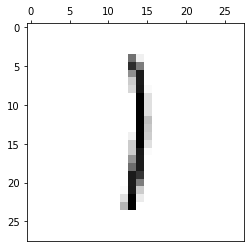

1
1


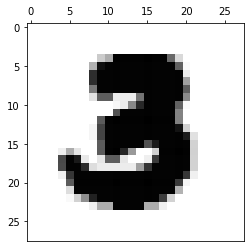

précision pour les données de test= tensor(97.5800)


In [29]:
#show the images with the predicted labels
with torch.no_grad():
    y=net(x_test_torch)
_, pred_labels_sgd = y.max(1)
pred_labels_sgd = pred_labels_sgd.numpy()


x_test_im = x_test.reshape((28, 28, 1, -1))

MNISTtools.show(x_test_im[:, :, 0, 40])
print(y_test[40])
print(pred_labels_sgd[40])
plt.show()
MNISTtools.show(x_test_im[:, :, 0, 200])
plt.show()
#accuracy of the network on the test set
with torch.no_grad():
    y=net(x_test_torch)
_, pred_labels_sgd = y.max(1)
print("précision pour les données de test=",100 * (y_test_torch == pred_labels_sgd).float().mean())

